# Group 7 Project

In [308]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
import tensorflow as tf

## Retrieving Data

In [309]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [310]:
df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Processing

Remove any closed stores or stores with 0 sales:

In [311]:
df = df.drop(df[df.Open == 0].index)
df = df.drop(df[df.Sales == 0].index)

Convert for time series:

In [312]:
df['Date'] = pd.to_datetime(df['Date'])

Merge the two dataframes:

In [313]:
df = pd.merge(df, store_df, how='inner', on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        842152 non-null  float64 

### Handling Missing Values

In [315]:
df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [316]:
#Since there are only 3 missing values replace with median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace = True)

#fill the rest with 0
df.fillna(0, inplace = True)

## Feature Engineering

Replace '0' with na values:

In [317]:
df['StateHoliday'] = df.StateHoliday.replace([0, '0'], np.nan)
df.StateHoliday.unique()

array([nan, 'a', 'b', 'c'], dtype=object)

### Dummy Encoding

In [318]:
dummy_columns = ['StoreType', 'Assortment', 'StateHoliday']
df = pd.get_dummies(df, columns=dummy_columns)

In [319]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   SchoolHoliday              844338 non-null  int64         
 8   CompetitionDistance        844338 non-null  float64       
 9   CompetitionOpenSinceMonth  844338 non-null  float64       
 10  CompetitionOpenSinceYear   844338 non-null  float64       
 11  Promo2                     844338 non-null  int64   

### Working with Time

In [321]:
#Splitting the Date as Day, month and year and adding 3 new columns
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekofyear'] = df['Date'].dt.weekofyear

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [322]:
#How long the competition has been open
df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)

In [323]:
#How long the promo has been running
df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.Weekofyear - df.Promo2SinceWeek) / 4.0

In [324]:
df = df.drop(columns=['Weekofyear','Promo2SinceWeek', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'CompetitionOpenSinceYear', 'Open', 'PromoInterval'])

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844338 non-null  int64         
 1   DayOfWeek            844338 non-null  int64         
 2   Date                 844338 non-null  datetime64[ns]
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   SchoolHoliday        844338 non-null  int64         
 7   CompetitionDistance  844338 non-null  float64       
 8   Promo2               844338 non-null  int64         
 9   StoreType_a          844338 non-null  uint8         
 10  StoreType_b          844338 non-null  uint8         
 11  StoreType_c          844338 non-null  uint8         
 12  StoreType_d          844338 non-null  uint8         
 13  Assortment_a  

In [326]:
#replace competitiondistance with furthest variable
df['CompetitionDistance'] = df.CompetitionDistance.replace(np.nan, df['CompetitionDistance'].max())
                                                           
#Competittion Open - use mean
df['CompetitionOpen'] = df.CompetitionOpen.replace(np.nan, df['CompetitionOpen'].max())

#PromoOpen - recode missing as 0
df['PromoOpen'] = df.PromoOpen.replace(np.nan, 0)

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844338 non-null  int64         
 1   DayOfWeek            844338 non-null  int64         
 2   Date                 844338 non-null  datetime64[ns]
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   SchoolHoliday        844338 non-null  int64         
 7   CompetitionDistance  844338 non-null  float64       
 8   Promo2               844338 non-null  int64         
 9   StoreType_a          844338 non-null  uint8         
 10  StoreType_b          844338 non-null  uint8         
 11  StoreType_c          844338 non-null  uint8         
 12  StoreType_d          844338 non-null  uint8         
 13  Assortment_a  

## Removing Outliers

In [328]:
for column in df.columns:
    print(column, df[column].dtypes)

Store int64
DayOfWeek int64
Date datetime64[ns]
Sales int64
Customers int64
Promo int64
SchoolHoliday int64
CompetitionDistance float64
Promo2 int64
StoreType_a uint8
StoreType_b uint8
StoreType_c uint8
StoreType_d uint8
Assortment_a uint8
Assortment_b uint8
Assortment_c uint8
StateHoliday_a uint8
StateHoliday_b uint8
StateHoliday_c uint8
Day int64
Month int64
Year int64
CompetitionOpen float64
PromoOpen float64


In [329]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df.Sales))
z_scores

array([0.54544483, 0.62373562, 0.70041548, ..., 0.88728236, 0.7654967 ,
       0.6056933 ])

In [330]:
removed_df = df[z_scores < 3]
print('Removed data', len(df) - len(removed_df))
df = removed_df

Removed data 13443


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830895 entries, 0 to 844337
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                830895 non-null  int64         
 1   DayOfWeek            830895 non-null  int64         
 2   Date                 830895 non-null  datetime64[ns]
 3   Sales                830895 non-null  int64         
 4   Customers            830895 non-null  int64         
 5   Promo                830895 non-null  int64         
 6   SchoolHoliday        830895 non-null  int64         
 7   CompetitionDistance  830895 non-null  float64       
 8   Promo2               830895 non-null  int64         
 9   StoreType_a          830895 non-null  uint8         
 10  StoreType_b          830895 non-null  uint8         
 11  StoreType_c          830895 non-null  uint8         
 12  StoreType_d          830895 non-null  uint8         
 13  Assortment_a  

# CNN Model

In [332]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [333]:
df

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_a,StateHoliday_b,StateHoliday_c,Day,Month,Year,CompetitionOpen,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,1270.0,0,0,0,1,0,1,0,0,0,0,0,31,7,2015,82.0,24187.75
1,1,4,2015-07-30,5020,546,1,1,1270.0,0,0,0,1,0,1,0,0,0,0,0,30,7,2015,82.0,24187.75
2,1,3,2015-07-29,4782,523,1,1,1270.0,0,0,0,1,0,1,0,0,0,0,0,29,7,2015,82.0,24187.75
3,1,2,2015-07-28,5011,560,1,1,1270.0,0,0,0,1,0,1,0,0,0,0,0,28,7,2015,82.0,24187.75
4,1,1,2015-07-27,6102,612,1,1,1270.0,0,0,0,1,0,1,0,0,0,0,0,27,7,2015,82.0,24187.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,1,2013-01-07,9291,1002,1,0,1100.0,0,1,0,0,0,1,0,0,0,0,0,7,1,2013,43.0,24156.50
844334,292,6,2013-01-05,2748,340,0,0,1100.0,0,1,0,0,0,1,0,0,0,0,0,5,1,2013,43.0,24156.25
844335,292,5,2013-01-04,4202,560,0,1,1100.0,0,1,0,0,0,1,0,0,0,0,0,4,1,2013,43.0,24156.25
844336,292,4,2013-01-03,4580,662,0,1,1100.0,0,1,0,0,0,1,0,0,0,0,0,3,1,2013,43.0,24156.25


In [334]:
df.set_index(['Date'],inplace=True)

In [335]:
df = df['Sales'].resample('D').sum()

In [336]:
df=pd.DataFrame(df)
df

,Sales
Date,
2013-01-01,79968
2013-01-02,6788268
2013-01-03,6217060
2013-01-04,6510796
2013-01-05,5837518
...,...
2015-07-27,9923943
2015-07-28,8754489
2015-07-29,8197327


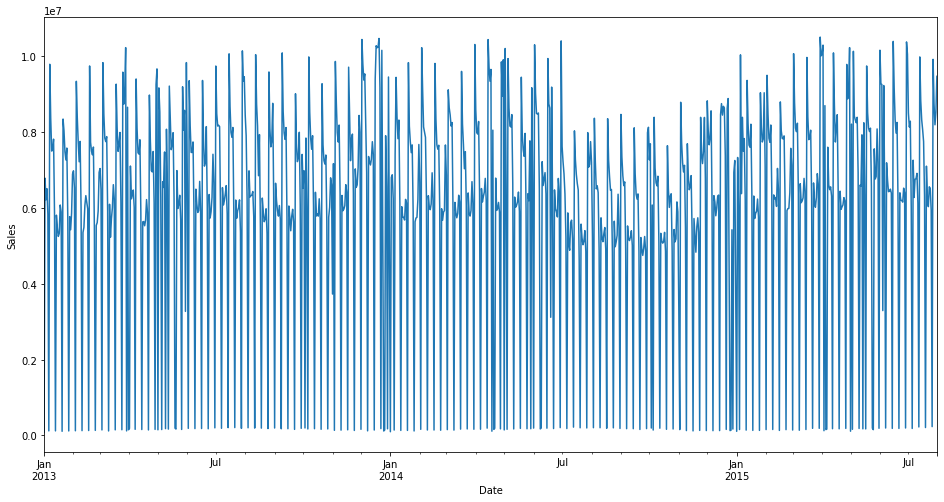

In [337]:
plt.figure(figsize=(16,8))
df['Sales'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [338]:
df_1=df.values
df_1=df_1.astype('float32')

scaler = MinMaxScaler(feature_range=(-1,1))
myscaler = scaler.fit(df_1)
ts = myscaler.transform(df_1)
ts

array([[-1.        ],
       [ 0.2861538 ],
       [ 0.17663848],
       [ 0.23295522],
       [ 0.10387051],
       [-0.9921976 ],
       [ 0.86248577],
       [ 0.58926487],
       [ 0.4235536 ],
       [ 0.42820227],
       [ 0.483752  ],
       [ 0.10971761],
       [-0.99212533],
       [ 0.09916675],
       [ 0.03391302],
       [-0.00827503],
       [ 0.00672543],
       [ 0.1505189 ],
       [ 0.11537862],
       [-0.9942928 ],
       [ 0.5853611 ],
       [ 0.52559924],
       [ 0.42001665],
       [ 0.3785355 ],
       [ 0.43867123],
       [ 0.08172882],
       [-0.99248654],
       [ 0.09141946],
       [ 0.02548933],
       [ 0.10997868],
       [ 0.30704176],
       [ 0.3235184 ],
       [ 0.23687196],
       [-0.9915904 ],
       [ 0.7763449 ],
       [ 0.5922073 ],
       [ 0.4682846 ],
       [ 0.36924362],
       [ 0.47226214],
       [ 0.13371241],
       [-0.9909974 ],
       [ 0.01130557],
       [ 0.03746128],
       [ 0.14784372],
       [ 0.19787228],
       [ 0

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   942 non-null    int64
dtypes: int64(1)
memory usage: 14.7 KB


In [340]:
timestep = 30

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 850
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]    

In [341]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=200, verbose=0)

In [342]:
Xtest = X[k:,:,:]  
Ytest= Y[k:]  

In [343]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

1422389500000.0

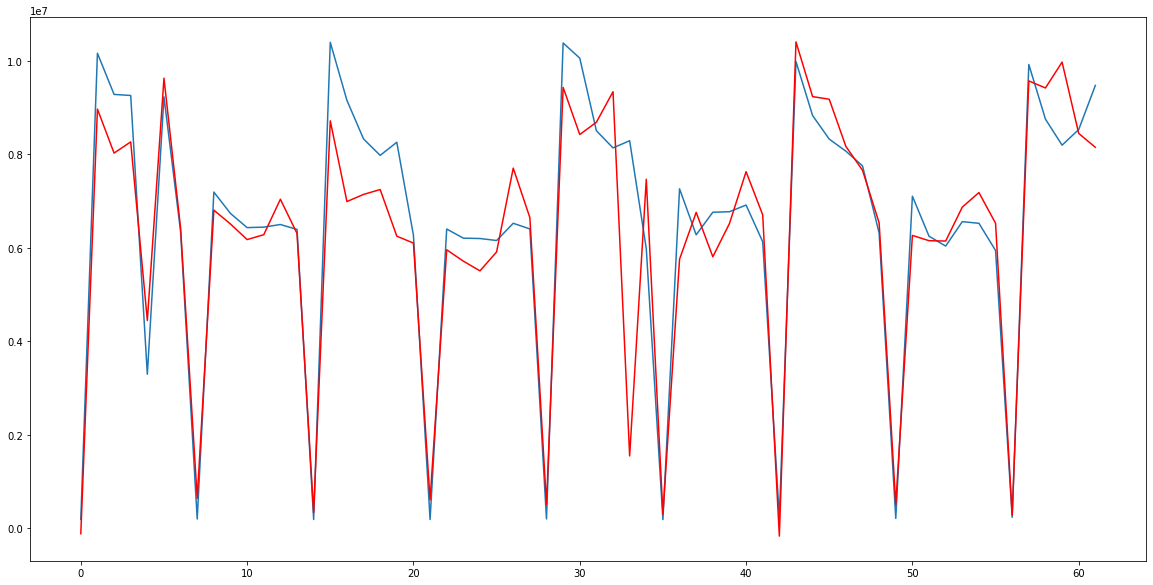

In [344]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()